In [25]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from motion_models import MM_CTRV, MM_CA
from simulation import *
from scenarios import get_scenario

# selecting scenario and generating GT
T = 0.05
sc_id = '4'
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
frame_vec = np.arange(n_frames)  

m_ctrv = MM_CTRV(0, 0)
sim_state = simulate_motion_CTRV(T, n_frames, sc['x_init'], m_ctrv, sc['manx_frames'])

In [26]:
sim_state.shape

(5, 400)

In [27]:
# filter evaluation
from filters import EKF_CTRV, UKF_CTRV

# experiment parameters
SEED = 1
n_iter = 10
std_r = 0.5
std_phi = np.radians(2)
var_v = 3**2
var_w = np.radians(10)**2
kf_vec = [
    {'label': 'EKF', 'filter': EKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#cd5c5c'},
    {'label': 'UKF', 'filter': UKF_CTRV(T, var_v, var_w, std_r, std_phi), 'color': '#32cd32'},
    # {'label': 'UKF', 'filter': UKF_CTRV(T, var_v, var_w, std_r, std_phi)},
]
np.random.seed(SEED)
n_filters = len(kf_vec)
X = np.zeros((5, n_frames, n_filters, n_iter)) # to store average state estimation
Err = np.zeros((5, n_frames, n_filters, n_iter)) # to store errors

for iter_ in range(n_iter):
    # generate measurements
    meas_pol = simulate_measurements_polar(sim_state, std_r, std_phi, 0.1)

    X_iter = np.zeros((5, n_frames, n_filters))
    Err_iter = np.zeros((5, n_frames, n_filters))

    for i, kf in enumerate(kf_vec):
        kf_f = kf['filter']
        for frame in frame_vec:
            meas = np.array([meas_pol[IMR, frame], meas_pol[IMPHI, frame]])
            if frame == 0:
                z0 = np.array([meas[0] * np.cos(meas[1]), meas[0] * np.sin(meas[1])])
                kf_f.initialize_filter(z0)
            else:
                kf_f.predict()
                kf_f.update(meas)
            X_iter[:, frame, i] = kf_f.x
            Err_iter[:, frame, i] = kf_f.x - sim_state[:, frame]
    
    X[:, :, :, iter_] = X_iter
    Err[:, :, :, iter_] = Err_iter

# getting metrics
Xm = np.mean(X, axis=3)
rmse_pos = np.sqrt(np.mean(Err[IX, :, :, :]**2 + Err[IY, :, :, :]**2, axis=2))
rmse_phi = np.degrees(np.sqrt(np.mean(Err[IPHI, :, :, :]**2, axis=2)))
rmse_vel = np.sqrt(np.mean(Err[IV, :, :, :]**2, axis=2))
rmse_omg = np.degrees(np.sqrt(np.mean(Err[IW, :, :, :]**2, axis=2)))

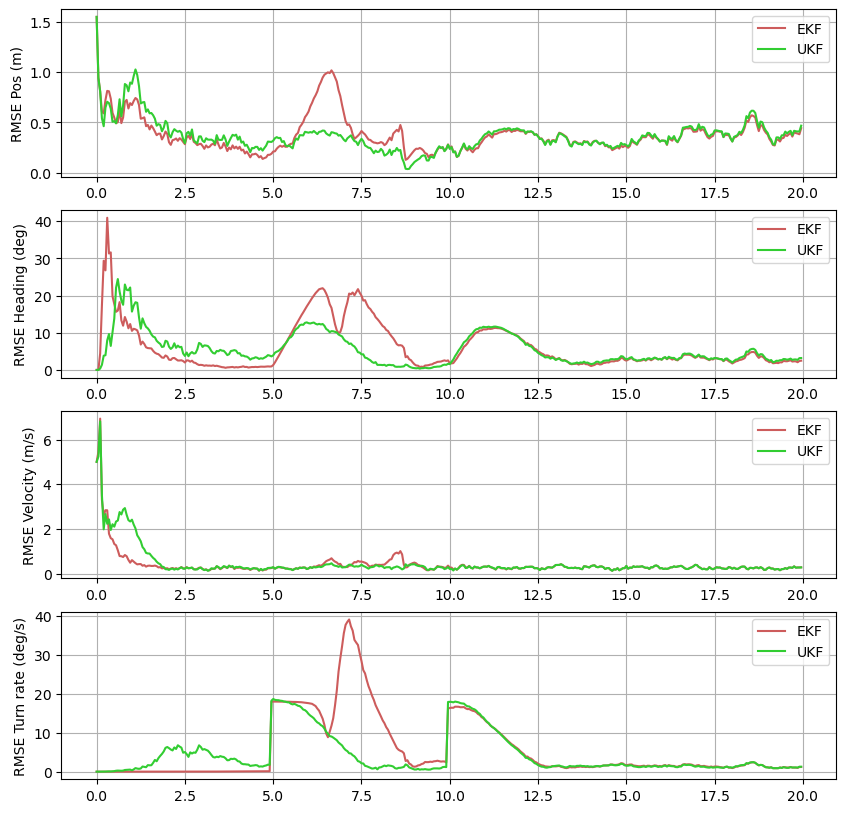

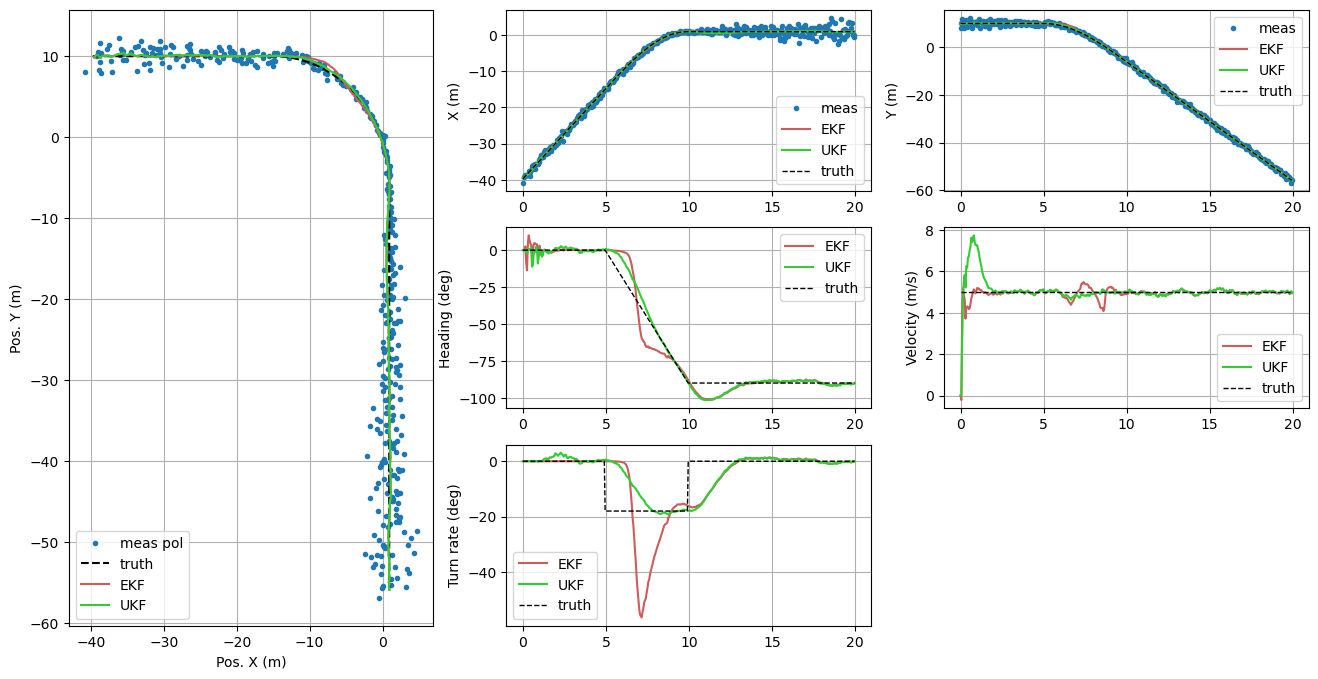

In [28]:
plot_options = [
    {'ylabel': 'RMSE Pos (m)', 'data': rmse_pos},
    {'ylabel': 'RMSE Heading (deg)', 'data': rmse_phi},
    {'ylabel': 'RMSE Velocity (m/s)', 'data': rmse_vel},
    {'ylabel': 'RMSE Turn rate (deg/s)', 'data': rmse_omg},
]
time_vec = frame_vec*T
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(4, 1)
for i, p in enumerate(plot_options):
    ax1 = fig.add_subplot(gs[i, 0])
    for i, kf in enumerate(kf_vec):
        ax1.plot(time_vec, p['data'][:, i], '-', label=kf['label'], color=kf['color'])
    ax1.set_ylabel(p['ylabel'])
    ax1.legend()
    ax1.grid()

# visualization
Xm[IPHI, :, :] = np.degrees(Xm[IPHI, :, :])
Xm[IW, :, :] = np.degrees(Xm[IW, :, :])
plot_options = [
    {'grid_pos': (0, 1), 'index': IX, 'ylabel': 'X (m)', 'meas_index': IMX},
    {'grid_pos': (0, 2), 'index': IY, 'ylabel': 'Y (m)', 'meas_index': IMY},
    {'grid_pos': (1, 1), 'index': IPHI, 'ylabel': 'Heading (deg)', 'fn': np.degrees},
    {'grid_pos': (1, 2), 'index': IV, 'ylabel': 'Velocity (m/s)'},
    {'grid_pos': (2, 1), 'index': IW, 'ylabel': 'Turn rate (deg)', 'fn': np.degrees},
]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(meas_pol[IMX, :], meas_pol[IMY], '.', label='meas pol')
ax1.plot(sim_state[IX, :], sim_state[IY, :], 'k--', label='truth')
for i, kf in enumerate(kf_vec):
    ax1.plot(Xm[IX, :, i], Xm[IY, :, i], '-', label=kf['label'], color=kf['color'])
ax1.legend()
ax1.grid()
ax1.set_xlabel('Pos. X (m)')
ax1.set_ylabel('Pos. Y (m)')
for p in plot_options:
    ax = fig.add_subplot(gs[*p['grid_pos']])
    sim_var = sim_state[p['index']]
    if p.get('meas_index', False):
        ax.plot(time_vec, meas_pol[p['meas_index'], :], '.', label='meas')
    if p.get('fn', False):
        sim_var = p['fn'](sim_var)
    for i, kf in enumerate(kf_vec):
        ax.plot(time_vec, Xm[p['index'], :, i], '-', label=kf['label'], color=kf['color'])
    ax.plot(time_vec, sim_var, 'k--', label='truth', linewidth=1)
    ax.set_ylabel(p['ylabel'])
    ax.legend()
    ax.grid()